In [1]:
import numpy as np
import pandas as pd
import joblib
import rasterio
from rasterio.crs import CRS
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

brt_model_path = "../models/brt_all_model.joblib.pkl"
brt = joblib.load(brt_model_path)
xgb_model_path = "../models/agb/xgb_all_model.joblib.pkl"
xgb = joblib.load(xgb_model_path)

# All variables
image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\ALL_EVAL.tif')
# Original Variables
# image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\ALL_EVAL.tif')
# Reduced Variables
# image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\S1A_DEM_INVEN_EVAL1.tif')



In [2]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

def plot_graph(result_data, file_name, mapStyle):
    fontprops = fm.FontProperties(size=12)
    # https://epsg.io/transform#s_srs=27700&t_srs=4326&x=293167.0000000&y=652518.0000000
    # topleft - x = -3°42.2263', y = 55°45.25162'
    # x = -3.7037717°, y = 55.7541937°
    # bottomright - x = -2.7696528°, y = 55.4075244°
    x_coord_l, x_coord_r = -3.7037717, -2.7696528
    y_coord_t, y_coord_b = 55.7541937, 55.4075244
    x_shape = result_data.shape[1]
    y_shape = result_data.shape[0]

    def x_format_func(value, tick_number):
        out = (x_coord_l + (value / x_shape * (x_coord_r - x_coord_l)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    def y_format_func(value, tick_number):
        out = (y_coord_t - (value / y_shape * (y_coord_t - y_coord_b)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    ax = plt.axes()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))
    # ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(y_format_func))
    # ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    scalebar = AnchoredSizeBar(ax.transData,
                               33.3, '10 km', 'lower right', 
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)


    plt.xlabel("Latitude")
    plt.ylabel("Londgitude")
    plt.imshow(result_data, cmap=mapStyle)
    plt.colorbar(label="Amount of Carbon (Mg C/ha)")
    plt.savefig(file_name)
    plt.show()

100%|██████████████████████████████████████████████████████| 132/132 [00:00<00:00, 159.23it/s]


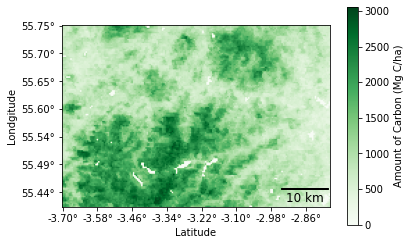

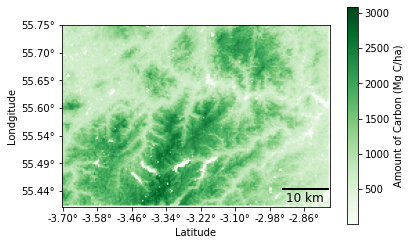

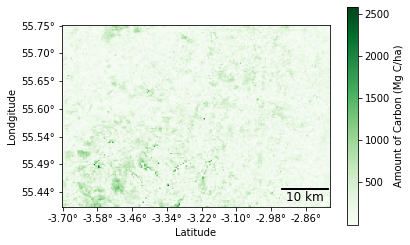

In [3]:
#brt

num_bands = image.count
img_width = image.width
img_height = image.height
num_pixels = img_height * img_width
all_data = []

for i in tqdm(range(num_bands)):
    data = image.read(i+1)
    data = pd.DataFrame(data).fillna(0).to_numpy()
    all_data.append(data)

all_data = np.dstack(all_data)
all_data_shape = all_data.shape

result_data = []
non_zero = 0
for t in tqdm(all_data):
    z = brt.predict(t)
    result_data.append(z)
    non_zero += np.count_nonzero(z)
    z[z!=z] = 0

brt_result = np.exp(np.stack(result_data))



soil_image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\Train_SG_15-30_27700_clipped.tif')
soil_gt_data = soil_image.read(1)

#  soc
plot_graph(soil_gt_data, '../report_output/experiment1/brt_all_truth.png', 'Greens')
plot_graph(brt_result, '../report_output/experiment1/brt_all_pred.png', 'Greens')
plot_graph(np.abs(soil_gt_data-brt_result[:131, :193]), '../report_output/experiment1/brt_all_err.png', 'Greens')


100%|██████████████████████████████████████████████████████| 132/132 [00:00<00:00, 193.83it/s]


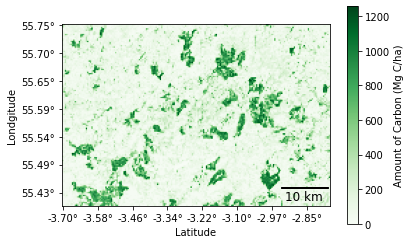

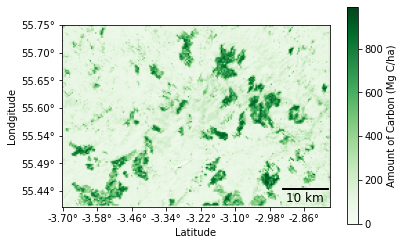

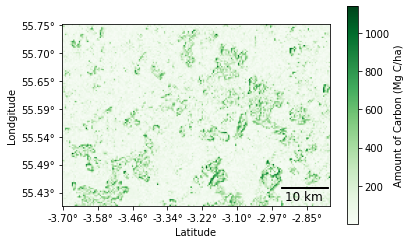

In [4]:
#xgb

num_bands = image.count
img_width = image.width
img_height = image.height
num_pixels = img_height * img_width
all_data = []

for i in tqdm(range(num_bands)):
    data = image.read(i+1)
    data = pd.DataFrame(data).fillna(0).to_numpy()
    all_data.append(data)

all_data = np.dstack(all_data)
all_data_shape = all_data.shape

result_data = []
non_zero = 0
for t in tqdm(all_data):
    z = xgb.predict(t)
    result_data.append(z)
    non_zero += np.count_nonzero(z)
    z[z!=z] = 0

xgb_result = np.stack(result_data)


agb_image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\agb_c1_27700_300m_clipped.tif')
agb_gt_data = agb_image.read(1)
# agb
plot_graph(agb_gt_data, '../report_output/experiment1/agb/agb_all_truth.png', 'Greens')
plot_graph(xgb_result, '../report_output/experiment1/agb_all_pred.png', 'Greens')
plot_graph(np.abs(agb_gt_data - xgb_result[:130, :192]), '../report_output/experiment1/agb_all_err.png', 'Greens')

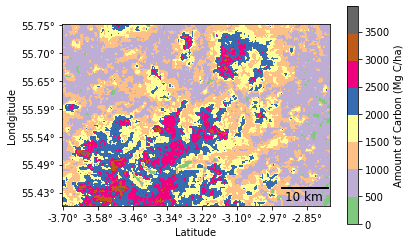

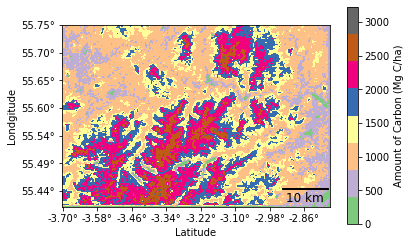

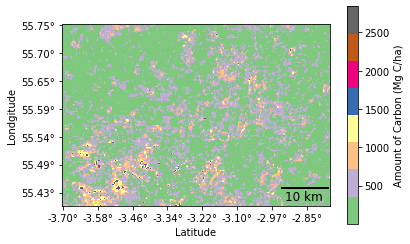

In [6]:
# Total Carbon
plot_graph(agb_gt_data + soil_gt_data[:130,:192], '../report_output/experiment1/total_all_truth.png', 'Accent')
plot_graph(xgb_result + brt_result, '../report_output/experiment1/total_all_pred.png', 'Accent')
plot_graph(np.abs(agb_gt_data - xgb_result[:130, :192]) + np.abs(soil_gt_data-brt_result[:131, :193])[:130,:192] , '../report_output/experiment1/total_all_err.png', 'Accent')